In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
words = open("J. K. Rowling - Harry Potter 1 - Sorcerer's Stone.txt", "r").read().splitlines()
words[:8]

["Harry Potter and the Sorcerer's Stone",
 '',
 '',
 'CHAPTER ONE',
 '',
 'THE BOY WHO LIVED',
 '',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, were proud to say']

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(chars)
print(itos)
print(vocab_size)

{1: '\t', 2: ' ', 3: '!', 4: '"', 5: "'", 6: '(', 7: ')', 8: '*', 9: ',', 10: '-', 0: '.', 12: '0', 13: '1', 14: '2', 15: '3', 16: '4', 17: '5', 18: '6', 19: '7', 20: '8', 21: '9', 22: ':', 23: ';', 24: '?', 25: 'A', 26: 'B', 27: 'C', 28: 'D', 29: 'E', 30: 'F', 31: 'G', 32: 'H', 33: 'I', 34: 'J', 35: 'K', 36: 'L', 37: 'M', 38: 'N', 39: 'O', 40: 'P', 41: 'Q', 42: 'R', 43: 'S', 44: 'T', 45: 'U', 46: 'V', 47: 'W', 48: 'X', 49: 'Y', 50: 'Z', 51: '\\', 52: 'a', 53: 'b', 54: 'c', 55: 'd', 56: 'e', 57: 'f', 58: 'g', 59: 'h', 60: 'i', 61: 'j', 62: 'k', 63: 'l', 64: 'm', 65: 'n', 66: 'o', 67: 'p', 68: 'q', 69: 'r', 70: 's', 71: 't', 72: 'u', 73: 'v', 74: 'w', 75: 'x', 76: 'y', 77: 'z', 78: '~'}
78


In [15]:
block_size = 3

def building_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = building_dataset(words[:n1])
Xdev, Ydev = building_dataset(words[n1:n2])
Xte,  Yte  = building_dataset(words[n2:])

torch.Size([353266, 3]) torch.Size([353266])
torch.Size([43432, 3]) torch.Size([43432])
torch.Size([43044, 3]) torch.Size([43044])


In [16]:
# setting up all the hyperparameters
num_emb = 10  # number of embedins
num_hidden = 300 # number of hidde neurons

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn(vocab_size, num_emb, generator = g)
W1 = torch.randn((num_emb * block_size), num_hidden, generator = g) * (5/3) / (num_emb * block_size)**0.5
W2 = torch.randn(num_hidden, vocab_size, generator = g) * 0.01
b2 = torch.randn(vocab_size, generator = g) * 0.01

# batch norm parameters
bngain = torch.ones((1, num_hidden))
bnbias = torch.zeros((1, num_hidden))
bnmean_running = torch.zeros((1, num_hidden))
bnstd_running = torch.ones((1, num_hidden))

parameters = [C, W1, W2 , b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True
print(sum(p.nelement() for p in parameters))

33858


In [17]:
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini-batch constrsuct
    ix = torch.randint(0, Xtr.shape[0], (block_size, ), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] # getting the embeddings in a tensor form
    embcat = emb.view(emb.shape[0], -1) # concatenating the vectors
    # linear layer
    hpreact = embcat @ W1 # hidden layer preactivation

    # batch normalization
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd  = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias # bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.99 * bnmean_running  + 0.001 * bnmean
        bnstd_running = 0.99 * bnstd_running + 0.001 * bnstd

    # Non linear layer
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backpass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.01 if i < 1050 else 0.0001
    for p in parameters:
        p.data += -lr * p.grad

    # stats
    if i % 1000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():4f}')
    lossi.append(loss.log10().item())

      0/  20000: 4.297331
   1000/  20000: 3.174091
   2000/  20000: 4.292986
   3000/  20000: 4.930440
   4000/  20000: 2.342440
   5000/  20000: 3.043882
   6000/  20000: 2.557816
   7000/  20000: 3.527438
   8000/  20000: 3.943960
   9000/  20000: 5.078980
  10000/  20000: 4.336607
  11000/  20000: 3.444632
  12000/  20000: 3.739810
  13000/  20000: 3.736296
  14000/  20000: 2.894144
  15000/  20000: 4.431051
  16000/  20000: 2.284151
  17000/  20000: 3.564610
  18000/  20000: 3.602532
  19000/  20000: 3.243625


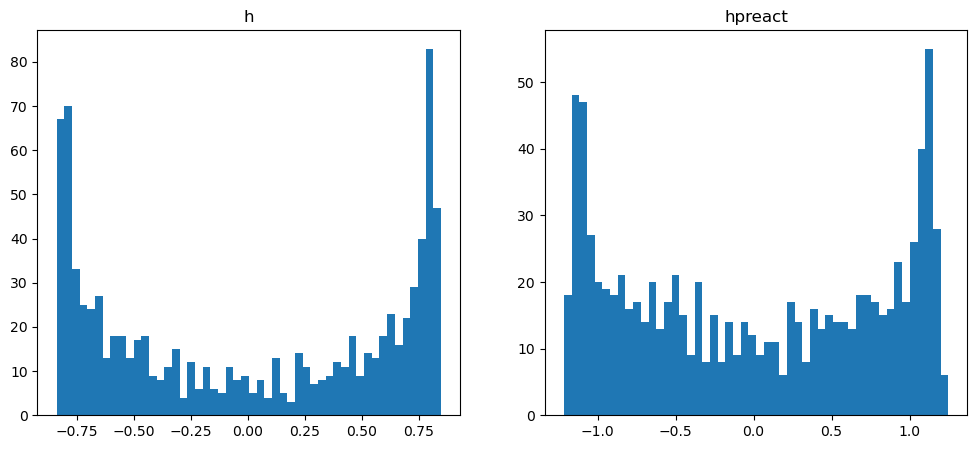

In [18]:
figs, ax = plt.subplots(1,2, figsize = (12, 5))
ax[0].hist(h.view(-1).tolist(), 50);
ax[0].set_title('h')
ax[1].hist(hpreact.view(-1).tolist(), 50);
ax[1].set_title('hpreact')
plt.show()

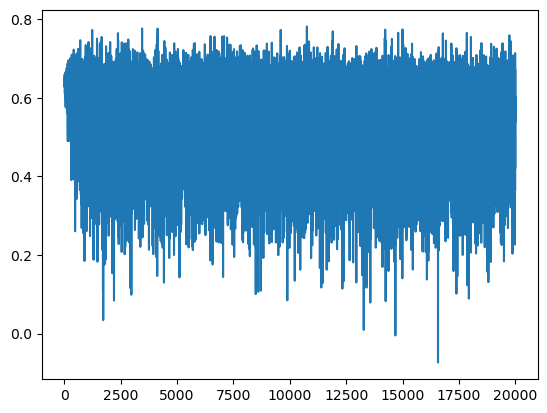

In [20]:
plt.plot(lossi)

In [21]:
#calibrating the norm at the end of the training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # measure the std and the mean over all the training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd  = hpreact.std(0, keepdim=True)

In [23]:
@torch.no_grad() # disabling the gradients
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('test')

train 3.4789304733276367
test 3.4781527519226074
